# Run Evaluation

In [1]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
print("Run at:", dt_string)

Run at: 29.05.2024 15:35:49


In [2]:
# Enable interactive plot
#@formatter:off
%matplotlib inline
%load_ext autoreload
%autoreload 2
#@formatter:on

import logging
log = logging.getLogger()

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch

import lightning as pl

from pathlib import Path
import importlib
import platform
import os
from copy import deepcopy

from run import path_resolution, evaluate, calc_step_hists

In [3]:
is_mac = platform.system() == 'Darwin'
is_computease = torch.cuda.is_available() and torch.cuda.get_device_name() == 'NVIDIA RTX A6000'
is_office_pc = torch.cuda.is_available() and torch.cuda.get_device_name() == 'NVIDIA GeForce GTX 1050 Ti'

is_mac, is_computease

(False, False)

In [4]:
if is_mac:
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [5]:
# use tensor cores
if is_computease:
    torch.set_float32_matmul_precision('medium') # TODO: consider if this should be higher

In [6]:
debug = False
debug_model = False
dry_run = False
num_worker = 20

SAMPLE_RATE = 30.0
plot_length = int(SAMPLE_RATE * 30) # ie half a minute

# -- sequence ----
# data = "RSO_LModule_Seq"

# # lib = "Sequence"
# # params = "hp_default"

# lib = "Sequence_pretrained"
# params = "hp_default"


# -- vector ----
# data = "RSO_LModule"
# lib = "OwnBaselineCNN"
# lib = "CNNModel_LiChan2014_AvgPool"
# lib = "CNNModel_LiChan2014"
# lib = "ResNet50_SunShangetAl"
# lib = "DenseNet"

# params = "hp_dropna"
# params = "hp_default"
# params = "hp_l1_loss"

# -- pre calced sequence ----
data = "T_LModule_Seq"

lib = "T_Sequence"
params = "hp_l1_loss"

data_loader_to_eval = 'gait_0' # all
# data_loader_to_eval = 'gait_1' # visible


distance_to_eval = 'd25'
# fig_dir = '../paper/smart-cities24/imgs/stride_length_estimation'
fig_dir = './imgs/'


In [7]:
interm_path = '_debug' if debug_model else ''

In [8]:
index_to_eval = f'{data_loader_to_eval}_{distance_to_eval}'
index_to_eval

'gait_0_d25'

In [9]:
# path resolution
base_path = path_resolution()

 -- rsync --
Calling: rsync -av /share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/data/ /share/data/yhartmann/data/ma-jonah/
sending incremental file list

sent 3,063 bytes  received 31 bytes  6,188.00 bytes/sec
total size is 20,528,940,833  speedup is 6,635,081.07
 -- rsync finished --

Base path: /share/data/yhartmann/data/ma-jonah/


In [10]:
plot_model_name = dict(OwnBaselineCNN="Baseline CNN", 
                       CNNModel_LiChan2014_AvgPool="LiChan14 AvgPool",
                       CNNModel_LiChan2014="LiChan14",
                       Sequence="Sequence",
                       DenseNet="DenseNet",
                       T_Sequence="Sequence",
                       ResNet50_SunShangetAl="ResNet50")[lib]
plot_model_name

'Sequence'

In [11]:
# resolve checkpoints
checkpoint_path = Path(f"./checkpoints{interm_path}/").resolve()
checkpoint_path.mkdir(parents=True, exist_ok=True)
model_checkpoint_path = f"{str(checkpoint_path / lib)}.{params}.ckpt"
print(f"model_checkpoint_path: {model_checkpoint_path}")

model_checkpoint_path: /share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/pipeline/checkpoints/T_Sequence.hp_l1_loss.ckpt


In [12]:
# model_checkpoint_path = "/share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/pipeline/checkpoints/ResNet50_SunShangetAl/hp_dropna/checkpoints/test.ckpt"
# model_checkpoint_path = "/share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/pipeline/checkpoints/ResNet50_SunShangetAl.hp_l1_loss.ckpt"

# Load model

In [13]:
NNModule = importlib.import_module(f"models.{lib}")
NeuralNetwork = getattr(NNModule, "NeuralNetwork")

## Create Datasets

In [14]:
hyper_params = deepcopy(getattr(NNModule, params))
hyper_params['trainer_params']['devices'] = 1

if is_mac:
    hyper_params['trainer_params']['accelerator'] = "mps"
    num_worker = 1

if not is_computease:
    hyper_params['data_params']['batch_size'] = round(hyper_params['data_params']['batch_size'] / 4)

if is_office_pc:
    num_worker = 10

hyper_params

{'loss_function': L1Loss(),
 'optimizer': torch.optim.adam.Adam,
 'data_params': {'batch_size': 64,
  'context': 15,
  'shuffle': True,
  'file': 'ResNet50_SunShangetAl.hp_l1_loss'},
 'model_params': {'input_size': 63,
  'output_size': 63,
  'hidden_size': 1024,
  'num_layers': 1},
 'scheduler_params': {'milestones': [10, 20], 'gamma': 0.1},
 'optimizer_params': {'lr': 0.0001},
 'trainer_params': {'max_epochs': 300, 'precision': '32', 'devices': 1},
 'early_stopping_params': {'monitor': 'val_loss',
  'mode': 'min',
  'patience': 5}}

In [15]:
# construct data module
DLModule = getattr(importlib.import_module(f"datasets.{data}"), data)
data_module = DLModule(data_dir=base_path, 
    n_jobs=num_worker, 
    debug=debug, 
    **hyper_params['data_params'])

/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
trainer = pl.Trainer(logger=False, 
            fast_dev_run=dry_run,
            default_root_dir=checkpoint_path, 
            **hyper_params['trainer_params'])

model = NeuralNetwork(model_params=hyper_params['model_params'],
                optimizer=hyper_params['optimizer'],
                loss_function=hyper_params['loss_function'],
                optimizer_params=hyper_params['optimizer_params'],
                scheduler_params=hyper_params['scheduler_params'])

metric_dict, ft_dict, prd_dict = evaluate(model, trainer, data_module, model_checkpoint_path, test=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_function'])`.
[codecarbon INFO @ 15:35:51] offline tracker init
[codecarbon WARNING @ 15:35:51] graceful shutdown. Exceptions:
[codecarbon WARNING @ 15:35:51] <class 'Exception'>
Traceback (most recent call last):
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages/codecarbon/core/util.py", line 23, in suppress
    yield
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages

2024-05-29 15:35:51,980 - run - INFO - ==== Predict ================================================


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2559.06it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 29746.84it/s]
Restoring states from the checkpoint path at /share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/pipeline/checkpoints/T_Sequence.hp_l1_loss.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /share/temp/yhartmann/smart-cities-journal-based-on-jonahs-ma/pipeline/checkpoints/T_Sequence.hp_l1_loss.ckpt


Predicting DataLoader 0: 100%|██████████| 409/409 [00:02<00:00, 146.91it/s]
2024-05-29 15:35:57,435 - run - INFO - Distance: 15
2024-05-29 15:35:57,436 - run - INFO - SP: 115.27
2024-05-29 15:35:57,436 - run - INFO - MSLD: -11.98
2024-05-29 15:35:57,436 - run - INFO - DR: 98.56
2024-05-29 15:35:57,437 - run - INFO - SDD: 9365
2024-05-29 15:35:57,845 - run - INFO - Distance: 20
2024-05-29 15:35:57,845 - run - INFO - SP: 107.46
2024-05-29 15:35:57,846 - run - INFO - MSLD: -7.23
2024-05-29 15:35:57,846 - run - INFO - DR: 98.12
2024-05-29 15:35:57,847 - run - INFO - SDD: 4589
2024-05-29 15:35:58,254 - run - INFO - Distance: 25
2024-05-29 15:35:58,255 - run - INFO - SP: 99.15
2024-05-29 15:35:58,255 - run - INFO - MSLD: -1.65
2024-05-29 15:35:58,255 - run - INFO - DR: 97.19
2024-05-29 15:35:58,256 - run - INFO - SDD: 778
2024-05-29 15:35:58,658 - run - INFO - Distance: 30
2024-05-29 15:35:58,658 - run - INFO - SP: 94.1
2024-05-29 15:35:58,659 - run - INFO - MSLD: 2.52
2024-05-29 15:35:58,65

[codecarbon WARNING @ 15:35:59] graceful shutdown. Exceptions:
[codecarbon WARNING @ 15:35:59] <class 'Exception'>
Traceback (most recent call last):
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages/codecarbon/core/util.py", line 23, in suppress
    yield
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/contextlib.py", line 79, in inner
    return func(*args, **kwds)
  File "/home/yale1/miniconda3/envs/smart-cities/lib/python3.10/site-packages/codecarbon/emissions_tracker.py", line 531, in stop
    if self._scheduler:
AttributeError: 'OfflineEmissionsTracker' object has no attribute '_scheduler'
[codecarbon WARNING @ 15:35:59] stopping.


# Metrics

In [17]:
metric_dict

{'gait_0_d15': {'prd_bone_stability': 1.0036645988506254,
  'prd_bone_stability_per_joint': {'Ab': 0.12750617926588226,
   'Chest': 0.20894716917914927,
   'Head': 0.5010440163565844,
   'Hip': 0.0,
   'LFArm': 1.0944014003192903,
   'LFoot': 0.694591092577461,
   'LHand': 0.5026436309317628,
   'LShin': 0.48277758585903685,
   'LShoulder': 0.36365933869478134,
   'LThigh': 1.6244054806642902,
   'LToe': 2.1325334658799346,
   'LUArm': 2.844792990100361,
   'Neck': 0.2983851348065758,
   'RFArm': 0.6586471559480523,
   'RFoot': 0.6651577686442786,
   'RHand': 0.7533099482732838,
   'RShin': 0.5077152853355581,
   'RShoulder': 0.36943772508403044,
   'RThigh': 1.8050287571977983,
   'RToe': 2.2291694816146195,
   'RUArm': 3.212802969130402},
  'sp': 115.26610644257703,
  'msld': -11.984229069848922,
  'dr': 98.56281541416429,
  'sdd': 9365.0},
 'gait_0_d20': {'prd_bone_stability': 1.0036645988506254,
  'prd_bone_stability_per_joint': {'Ab': 0.12750617926588226,
   'Chest': 0.20894716917

In [18]:
prediction, target = prd_dict[data_loader_to_eval]

In [19]:
prd_foots, prd_valleys = ft_dict[index_to_eval]['prd_foots'], ft_dict[index_to_eval]['prd_valley']
trg_foots, trg_valleys = ft_dict[index_to_eval]['trg_foots'], ft_dict[index_to_eval]['trg_valley']

In [20]:
# df = pd.DataFrame()

# context = 15 # use in case of sequence model, as essentially the first #context frames are used to predict frame 15

# a = np.zeros(trg_valleys.shape[0] + context)
# a[trg_foots['i']['LFoot'] + context] = 1
# df['Stride LFoot Motion Capture'] = a

# a = np.zeros(trg_valleys.shape[0] + context)
# a[trg_foots['i']['RFoot'] + context] = 1
# df['Stride RFoot Motion Capture'] = a

# a = np.zeros(trg_valleys.shape[0] + context)
# a[prd_foots['i']['LFoot'] + context] = 1
# df['Stride LFoot Depth'] = a

# a = np.zeros(trg_valleys.shape[0] + context)
# a[prd_foots['i']['RFoot'] + context] = 1
# df['Stride RFoot Depth'] = a

# df_seg = pd.read_csv('gait_segmentation.csv')
# df_seg = df_seg[df_seg['Session'] == 6]

# df_seg.join(df.set_index(df_seg.index)).to_csv('gait_strides.csv', index=False)

## Visualize Left Foot Speed

2024-05-29 15:35:59,570 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


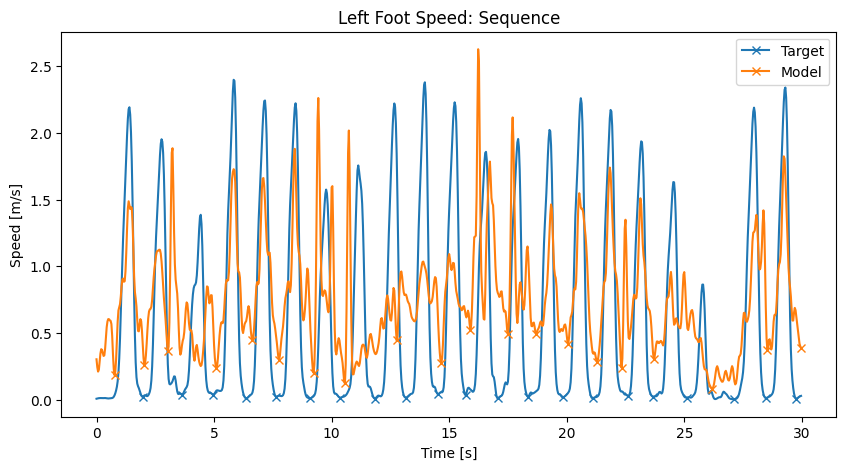

In [21]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

plt_trg_valleys = trg_valleys[:plot_length]
plt_trg_foots = trg_foots['i']['LFoot'][trg_foots['i']['LFoot'] < plot_length]
ax.plot(plt_trg_valleys['LFoot', 'Speed'].index / SAMPLE_RATE, plt_trg_valleys['LFoot', 'Speed'], '-x', markevery=plt_trg_foots, label="Target")

plt_prd_valleys = prd_valleys[:plot_length]
plt_prd_foots = prd_foots['i']['LFoot'][prd_foots['i']['LFoot'] < plot_length]
ax.plot(plt_prd_valleys['LFoot', 'Speed'].index / SAMPLE_RATE, plt_prd_valleys['LFoot', 'Speed'], '-x', markevery=plt_prd_foots, label="Model")

plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title(f"Left Foot Speed: {plot_model_name}")
plt.legend()
plt.savefig(f"{fig_dir}/speed_{lib}{interm_path}{params}_{data_loader_to_eval}.eps")
plt.show()

## Stride length distribution as histogram and histogram distance from ground truth

Auflösung Histogramm: 5.0 cm
2024-05-29 15:35:59,786 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


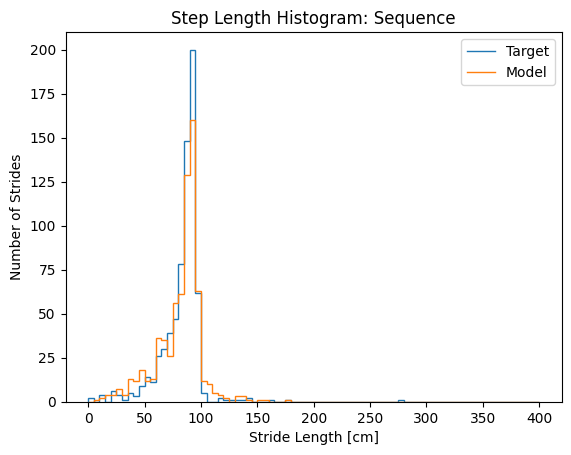

In [22]:
bins = 80

gt_counts, gt_bins, pred_counts, pred_bins = calc_step_hists(prd_foots, trg_foots, bins=bins)
print(f"Auflösung Histogramm: {np.round(gt_bins[1]-gt_bins[0], 2)} cm")

plt.figure()
plt.title(f'Step Length Histogram: {plot_model_name}')
plt.stairs(gt_counts, gt_bins, label="Target")
plt.stairs(pred_counts, pred_bins, label="Model")
plt.xlabel("Stride Length [cm]")
plt.ylabel("Number of Strides")
plt.legend()
plt.savefig(f"{fig_dir}/hist_{lib}{interm_path}{params}_{data_loader_to_eval}.eps")
plt.show()

## Print Stride length

In [23]:
for bone in ['LFoot', 'LToe', 'RFoot', 'RToe']:
    print(f"{bone}:")
#     print(f"  Ground Truth Stride length: \n{trg_foots.at[bone, 'stride_len']}")
    print(f"  Predicted Stride length: \n{prd_foots.at[bone, 'stride_len']}")

LFoot:
  Predicted Stride length: 
[ 94.23262439  63.83795684  29.48037633  94.74660647  94.69328255
  91.57794854  54.23336655  94.32484264 137.1277893   89.06752763
  84.31238461  63.6930281   69.17292913  88.15921156  91.10976357
  78.16498884  88.66180978  93.3484485   91.14329685  95.81882526
  73.75154566  26.47819123  61.3149524   99.75712364  91.45160696
  95.08332675  90.82334089  73.8121342   78.01518499  89.55611129
  92.04978572  96.35742647  58.66630359  78.01202815  80.70146811
  96.75922983  88.56588868  84.47922117  21.90525864  37.18780706
 111.52618148  83.97624419  54.74718189  97.36256581  68.721267
  65.74921877  84.23845604  93.23006283  82.37073926  55.42589008
  51.97206043  75.86135393 179.12056644  78.87076837  38.59228888
  60.91991306  78.44162381  77.71066499  91.7768238   89.05511103
  42.81540066  66.86381386  92.03275356  97.53088238  79.27473243
  38.58861745  35.3536502   62.48688146  93.15219788  90.29888388
  93.31980605  80.59311476  81.46555076  91

## Visualize Footsteps

2024-05-29 15:36:00,167 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


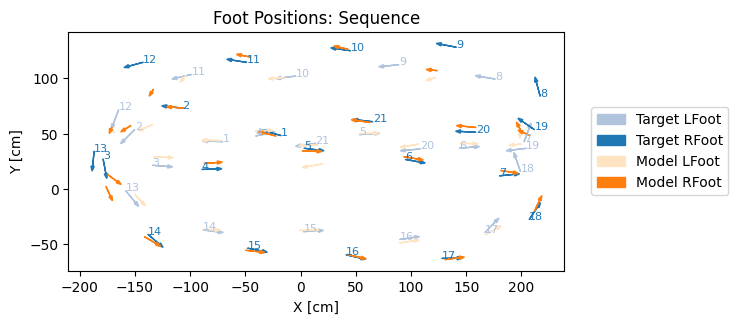

In [24]:
def draw_foot_arrows(foot_data, ax, left_color, right_color, max_frames=None, number=True, label=''):
    for f, t, color in [('LFoot', 'LToe', left_color), ('RFoot', 'RToe', right_color)]:
        for i, ((frame, foot), (_, toe)) in enumerate(zip(foot_data['pos'][f].iterrows(), foot_data['pos'][t].iterrows())):
        # for (frame, foot), (_, toe) in zip(foot_data['pos'][f].iterrows(), foot_data['pos'][t].iterrows()):
            if max_frames is not None and frame >= max_frames:
                break
            
            x = foot['X']
            y = foot['Z']
            d_x = toe['X'] - x
            d_y = toe['Z'] - y
            # rotate to match the camera view
            if i == 0:
                ax.arrow(y, x, d_y, d_x, color=color, head_width=3, label=f"{label} {f}")
            else:
                ax.arrow(y, x, d_y, d_x, color=color, head_width=3)
                
            if number:
                ax.text(y, x, i + 1, fontsize=8, color=color)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title(f'Foot Positions: {plot_model_name}')
ax.set(xlabel='X [cm]', ylabel='Y [cm]')

ax.set_aspect('equal', 'box')

draw_foot_arrows(trg_foots, ax, 'lightsteelblue', 'tab:blue', max_frames=plot_length, number=True, label='Target')
draw_foot_arrows(prd_foots, ax, 'bisque', 'tab:orange', max_frames=plot_length, number=False, label='Model')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.savefig(f"{fig_dir}/feet_{lib}{interm_path}{params}_{data_loader_to_eval}.eps", bbox_inches="tight")

# Plot Skeleton

In [25]:
prd_df = pd.DataFrame(prediction)
prd_df.columns = data_module.columns

trg_df = pd.DataFrame(target)
trg_df.columns = data_module.columns

prd_df

Ab                             Chest                         \
        Position                          Position                          
Frame          X           Y          Z          X           Y          Z   
0      33.539745  102.986862  15.288532  35.115997  117.678719  17.623968   
1      34.397781  102.927696  14.856162  35.856838  117.590797  17.226156   
2      34.172588  102.696243  14.797762  35.673725  117.334595  17.167246   
3      34.387268  102.991943  14.452819  35.883972  117.666870  16.822552   
4      34.568466  103.154625  13.972072  36.063210  117.857224  16.351851   
...          ...         ...        ...        ...         ...        ...   
26167   1.236649   99.539627  18.197216   2.993902  114.031403  20.080385   
26168  -1.415553  100.333900  14.544713   0.280315  114.888817  16.549524   
26169  -1.857549  101.023415  12.028550  -0.175886  115.657387  13.943981   
26170  -2.380132  101.192703  10.245084  -0.815612  115.907394  11.999174   
26171  -4.178625  101.687096   8.821141  -2.715552  116.495735  10.440743   

            Head                               Hip  ...  RShoulder     RThigh  \
        Position                          Position  ...   Position   Position   
Frame          X           Y          Z          X  ...          Z          X   
0      34.040981  148.115463  14.725407  33.550613  ...  22.773436  44.565830   
1      34.873672  147.991776  14.340997  34.394817  ...  22.502811  45.265785   
2      34.636654  147.657379  14.277749  34.168995  ...  22.398073  45.086887   
3      34.848709  148.051682  13.951768  34.381046  ...  22.043509  45.281158   
4      35.041737  148.298553  13.480729  34.537888  ...  21.602177  45.494743   
...          ...         ...        ...        ...  ...        ...        ...   
26167   1.062437  144.236511  18.454798   1.194088  ...  22.764071  10.148232   
26168  -1.728066  145.302780  14.897357  -1.428901  ...  19.134903   7.531218   
26169  -2.449170  146.328354  12.388420  -1.802824  ...  16.252378   6.872592   
26170  -3.234925  146.594437  10.506613  -2.269805  ...  14.459239   6.292552   
26171  -5.247145  147.213989   9.019004  -4.064085  ...  13.040729   4.336740   

                                  RToe                           RUArm  \
                              Position                        Position   
Frame          Y          Z          X         Y          Z          X   
0      94.968163  14.846502  48.336620  5.261646  12.161986  58.735535   
1      94.937561  14.775229  49.140465  5.281112  12.004996  59.062138   
2      94.715057  14.549912  49.057213  5.273695  11.347797  58.985416   
3      94.997078  14.218801  49.253761  5.305531  10.849904  59.143276   
4      95.130180  13.761561  49.413013  5.304127  10.880731  59.444485   
...          ...        ...        ...       ...        ...        ...   
26167  91.996681  16.204847  11.582130  5.236905  29.050663  22.008993   
26168  92.749641  12.574317   9.522821  5.531866  25.244936  19.342066   
26169  93.395309   9.698137   9.681747  5.785969  21.537848  18.217941   
26170  93.527138   8.028644   9.979186  5.920832  19.239115  17.359318   
26171  94.047638   6.591247   8.880976  6.056494  15.921885  15.253448   

                              
                              
Frame           Y          Z  
0      132.442627  21.656136  
1      132.344559  21.975388  
2      132.045517  21.663382  
3      132.411575  21.366695  
4      132.635239  20.929657  
...           ...        ...  
26167  129.188812  17.401144  
26168  130.194534  13.894276  
26169  131.160370  10.752477  
26170  131.388596   9.288157  
26171  132.044388   7.807207  

[26172 rows x 63 columns]

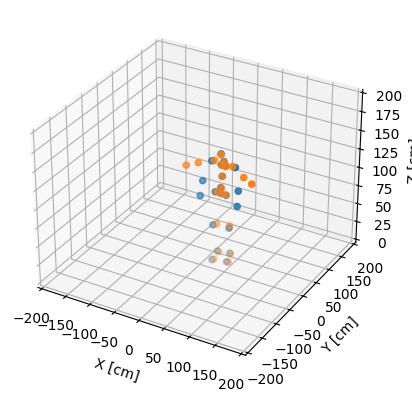

In [26]:
def get_bone_coordinates(df, idx):
    xs = df.xs('X', level=2, axis=1).iloc[idx].to_numpy()
    ys = df.xs('Y', level=2, axis=1).iloc[idx].to_numpy()
    zs = df.xs('Z', level=2, axis=1).iloc[idx].to_numpy()
    return xs, zs, ys # not sure why the columnes are in the wrong order in the df...

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim3d(-200, 200)
ax.set_ylim3d(-200, 200)
ax.set_zlim3d(0, 200)

prd_graph = ax.scatter(*get_bone_coordinates(prd_df, 0), c='tab:blue', label=plot_model_name)
trg_graph = ax.scatter(*get_bone_coordinates(trg_df, 0), c='tab:orange', label="Target")

def update(i):
    prd_graph._offsets3d = get_bone_coordinates(prd_df, i)
    trg_graph._offsets3d = get_bone_coordinates(trg_df, i)
    return prd_graph, trg_graph

# anim = animation.FuncAnimation(fig, update, frames=plot_length, interval=1000/SAMPLE_RATE, blit=True)
# HTML(anim.to_jshtml())

In [27]:
# anim = animation.FuncAnimation(fig, update, interval=1000/SAMPLE_RATE, blit=True)
# anim.save('eval.mp4', writer='ffmpeg', fps=SAMPLE_RATE)